# Bin daily ASC in 10 degree bins

In [2]:
# Load necessary modules
import intake
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
import cmocean.cm as cmocean
import glob
import matplotlib.path as mpath
import matplotlib.colors as col
import pandas as pd
import scipy.stats as stats
from tqdm import tqdm
import logging
import matplotlib.cm as cm
from xhistogram.xarray import histogram
import warnings

logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

In [3]:
import dask.config
from dask.distributed import Client,LocalCluster
from dask_jobqueue import PBSCluster

In [4]:
client = Client(threads_per_worker = 1)

In [5]:
iaf_cycle3 = '01deg_jra55v140_iaf_cycle3'
catalog = intake.cat.access_nri
ylength=580

In [6]:
#in this definition, no frequency can be used only for static data
def importer(experiment,catalog,variable, frequency = 'fx',start_time=0,end_time=0):
    warnings.filterwarnings('ignore')
    if experiment== "panant-01-zstar-ACCESSyr2":
        var = catalog[experiment].search(variable=variable, frequency = frequency).to_dask(xarray_open_kwargs={'decode_timedelta':True})
    else: 
        #other resolutions have the same variable with z_l and z_l_sub z dim in different times.
        # I will filter to the time I want knowing th their specificities
        #IOW this fix works just for the models and variables used in this notebook
        if variable=='uo' or variable=='vo':
            var = catalog[experiment].search(variable=variable, frequency = frequency)
            keysnames = var.keys() ; search_term = "z_l_sub01"
            matches = [s for s in keysnames if search_term in s]
            var = catalog[experiment].search(variable=variable, frequency = frequency,file_id = matches).to_dask(xarray_open_kwargs={'decode_timedelta':True})
        else:
            var = catalog[experiment].search(variable=variable, frequency = frequency).to_dask(xarray_open_kwargs={'decode_timedelta':True})
    
    if start_time!=0:
        time_slice='slice(start_time,end_time)'
        return eval("var." + variable + ".sel(time=" + time_slice + ")")
    elif start_time ==0:
        return eval("var." + variable)

In [7]:
# #first, creating the Z mask so we make sure we get the right sigmas in the right locations
CSHTZC_z = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/Cross_slope_heat_transport/OM2_IAF/daily_z/*')

In [8]:
#importing 3deg binned ASC speed along and cross contour
#importing the daily ualong in z coords
u_along_unbinned_fine_z = xr.open_mfdataset('/g/data/x77/wf4500/ASC_project/ASC_speed/daily_z/OM2_IAF_XYgrid/*')
#importing the daily ualong in z coords, 3deg binned 
u_along_binned_z = xr.open_mfdataset('/g/data/x77/wf4500/ASC_project/ASC_speed/daily_z_3deg/along_slope/*')

In [9]:
#lighter CSHT matrix to make easier to find TS along isobath
CSHT_along = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/Cross_slope_heat_transport/OM2_IAF/WMbins_daily_rho/*')
CSHT_along = CSHT_along.isel(time=0).drop('time')

In [10]:
# #importing dzt monthly. This will have to be interpoalted in time
# dzt_3d_monthly= cc.querying.getvar(iaf_cycle3,'dzt', session,frequency='1 monthly',chunks={}).isel(yt_ocean=slice(0,ylength))



# #age from the end of iaf  yle 2, to appemnd to the cycle 3
# dzt_IC= cc.querying.getvar('01deg_jra55v140_iaf_cycle2','dzt' , session,n=-1,chunks={})\
# .isel(yt_ocean=slice(0,ylength)).isel(time=-1,drop=True)

# #age for the beggining of cycle 4 to append to data
# dzt_ICf= cc.querying.getvar('01deg_jra55v140_iaf_cycle4','dzt' , session,n=0,chunks={})\
# .isel(yt_ocean=slice(0,ylength)).isel(time=0,drop=True)


# #correcting the time edges for creating of the new cocated data
# dzt_IC = dzt_IC.expand_dims(time = time_edge0_age)
# dzt_ICf = dzt_ICf.expand_dims(time = time_edgef_age)


# # #creating the age var with the halo
# dzt_3d_monthly = xr.concat((dzt_IC,dzt_3d_monthly,dzt_ICf),dim = 'time')
# print('time-halo created around zt')

In [11]:
#area
area = importer(iaf_cycle3,catalog,'area_t').isel(yt_ocean=slice(0,ylength))
area_transect = area.sel(xt_ocean = CSHT_along.lon_along_contour,yt_ocean=CSHT_along.lat_along_contour,method='nearest')
area_transect.load()
print('Loaded area along the isobath')

Loaded area along the isobath


In [12]:
def binning_area_3deg( u_along_binned_z, area_transect):
    
    #binning into 3deg
    bin_width = 3
    bin_spacing = 0.25
    lon_west = -280
    lon_east = 80
    
    # new coordinate and midpoints of longitude bins:
    full_lon_coord = np.arange(lon_west,lon_east+bin_spacing,bin_spacing)
    lon_bin_midpoints = np.arange(lon_west+bin_width/2,lon_east-bin_width/2,bin_spacing)
    
    n_bin_edges = len(full_lon_coord)
    lon_along_contour = np.array(CSHT_along.lon_along_contour)
    lat_along_contour = np.array(CSHT_along.lat_along_contour)
    
    
    bin_edge_indices = np.zeros(n_bin_edges)
    for lon_bin in range(n_bin_edges-1):
        # find first isobath point that has the right longitude:
        first_point = np.where(lon_along_contour>=full_lon_coord[lon_bin])[0][0]
        # then find all other isobath points with the same longitude as that first point:
        same_lon_points = np.where(lon_along_contour==lon_along_contour[first_point])[0]
        # we want the most southerly of these points on the same longitude line:
        bin_edge_indices[lon_bin] = same_lon_points[np.argmin(lat_along_contour[same_lon_points])]
        
    # define east/west edges:
    bin_edge_indices = bin_edge_indices.astype(int)
    bin_edge_indices_west = bin_edge_indices[:-int(bin_width/bin_spacing)-1]
    bin_edge_indices_east = bin_edge_indices[int(bin_width/bin_spacing):-1]
    n_bins = len(bin_edge_indices_west)
    
    
    lat_bin_midpoints = np.zeros(n_bins)
    for lon_bin in range(n_bins):
        # find nearest isobath point:
        lon_index = np.where(lon_along_contour>=lon_bin_midpoints[lon_bin])[0][0]
        lat_bin_midpoints[lon_bin] = lat_along_contour[lon_index]
    
    
    area_contour_3deg = np.zeros(u_along_binned_z.isel(time=0).u_along_contour_binned.shape[1])*np.nan
    for lon_bin in range(n_bins):
        area_contour_3deg0 = area_transect[bin_edge_indices_west[lon_bin]:bin_edge_indices_east[lon_bin]]
        area_contour_3deg[lon_bin] = (np.nansum(area_contour_3deg0))
    
    #removing zeros
    area_contour_3degnp = np.where(area_contour_3deg!=0,area_contour_3deg,np.nan)
    
    #volumes_rho
    area_contour_3deg = u_along_binned_z.u_along_contour_binned.isel(time=0,st_ocean=0).copy()
    area_contour_3deg.name = 'Area'
    area_contour_3deg.values = area_contour_3degnp
    
    
    return area_contour_3deg

In [ ]:
%%time
#doing the whole procedule monthly.
savedir_U = '/g/data/x77/wf4500/ASC_project/ASC_z_daily_10deg/OM2_01_iaf_cycle3/'
lon_bin=10
bin_edges = np.arange(CSHTZC_z.lon_bin_midpoints[0], CSHTZC_z.lon_bin_midpoints[-1]+(lon_bin/2), lon_bin)
lon_bin_mid = np.arange((bin_edges[0]+(lon_bin/2)),(bin_edges[-1]+(lon_bin/2)),lon_bin) # for 10-deg bins
newlon = np.concatenate((CSHTZC_z.lon_bin_midpoints.values,np.arange(78.5,81.5,.25)), axis=0)
longfix = xr.DataArray(newlon, coords={'lon_bin_midpoints': newlon},dims=['lon_bin_midpoints'])
meantime = CSHTZC_z.time.resample(time='1M').mean()
for n in tqdm(range(meantime.time.count().values)):
    #rint(str(n) + '-' + str((n+1) +1) + '\n \n')
    start_monthly_age = meantime.time.isel(time=0) #real start monthly age to use for interpolation
    end_monthly_age = meantime.time.isel(time=-1) #real end monthly age to use for interpolation
    # #the target year is
    target_year = str(meantime.time.dt.year[n].values)
    target_month = str(meantime.time.dt.month[n].values)
    target_start_time=target_year + '-' + target_month.zfill(2) + '-01'
    # #creating the matrix of daily times for interpolation
    target_daily_time = u_along_binned_z.time.sel(time = target_year + '-' + target_month.zfill(2) )
    # #calculating the volume of each cell
    area_contour_3deg = binning_area_3deg(u_along_binned_z, area_transect)
    area_contour_3deg_halo = xr.concat([area_contour_3deg,area_contour_3deg.isel(lon_bin_midpoints=slice(0,12))], dim='lon_bin_midpoints')
    area_contour_3deg_halo['lon_bin_midpoints'] = longfix
    area_10deg_binned = area_contour_3deg_halo.groupby_bins('lon_bin_midpoints', bins=bin_edges).sum('lon_bin_midpoints')
    # #NOW U
    U=u_along_binned_z.u_along_contour_binned.sel(time=target_daily_time)
    U_3deg_halo = xr.concat([U,U.isel(lon_bin_midpoints=slice(0,12))], dim='lon_bin_midpoints')
    U_3deg_halo['lon_bin_midpoints'] = longfix
    U_3deg_halo = U_3deg_halo* area_contour_3deg_halo #contour density multiplied by the volume in z coordinates
    U_10deg_binned = U_3deg_halo.groupby_bins('lon_bin_midpoints', bins=bin_edges).sum('lon_bin_midpoints') /\
    area_contour_3deg_halo.groupby_bins('lon_bin_midpoints', bins=bin_edges).sum('lon_bin_midpoints')
    # #some renaming to make things easier
    U_10deg_binned = U_10deg_binned.rename({'lon_bin_midpoints_bins':'lon_bins'})
    # #some renaming and binning correction prior to saving
    U_10deg_binned.name='U'
    U_10deg_binned['lon_bins'] = lon_bin_mid
    # # # #saving the interpolated age data
    U_10deg_binned.to_netcdf(savedir_U + 'U_daily_10deg_z_' +  target_year + '-' + target_month.zfill(2) +'.nc')
    print(target_year + '-' + target_month.zfill(2) + ' done...')
print('Daily age masks created and saved')

## Sanity check on 10-degree binned ASC speeds

In [41]:
ASC_10deg_bins = xr.open_mfdataset(savedir_U+'*.nc').compute()

(1200.0, 0.0)

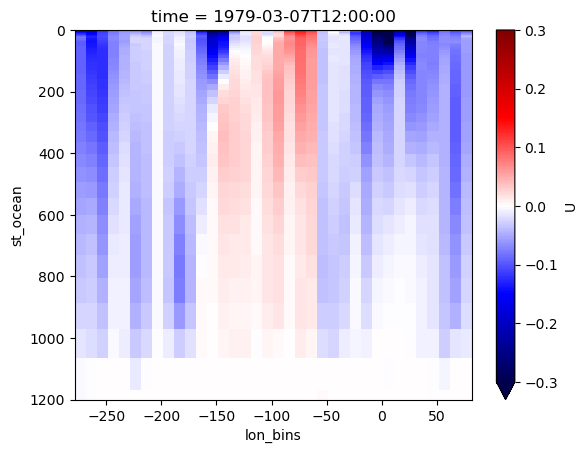

In [51]:
#view test
from random import randint as randint
#random time index for testing
Tind = randint(0,ASC_10deg_bins.time.count().values)

ASC_10deg_bins.U.isel(time=Tind).plot(vmin=-.3,vmax=.3,cmap='seismic')
plt.ylim(1200,0)


Out of curiosity, what are the locations with the highest SD in ASC speed? Probably the surface, but let's check

(1200.0, 0.0)

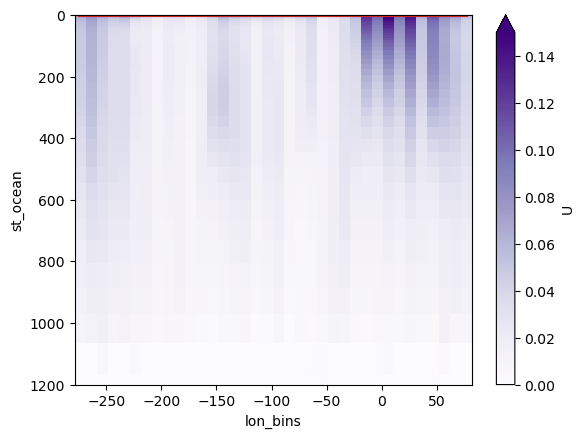

In [63]:
ASC_10deg_bins.U.std('time').plot(vmin=0,vmax=.15,cmap='Purples')
ASC_10deg_bins.st_ocean.isel(st_ocean=ASC_10deg_bins.U.std('time').argmax('st_ocean')).plot(x='lon_bins',color='tab:red',linewidth=3)
plt.ylim(1200,0)
#maximum standard deviation/variability seem to be always at the surface

##  Binning Cross-slope speed

In [13]:
#importing the daily ualong in z coords, 3deg binned 
v_cross_binned_z = xr.open_mfdataset('/g/data/x77/wf4500/ASC_project/ASC_speed/daily_z_3deg/cross_slope/*')

In [14]:
%%time
#doing the whole procedule monthly.
savedir_U = '/g/data/x77/wf4500/ASC_project/ASC_cross_z_daily_10deg/OM2_01_iaf_cycle3/'
lon_bin=10
bin_edges = np.arange(CSHTZC_z.lon_bin_midpoints[0], CSHTZC_z.lon_bin_midpoints[-1]+(lon_bin/2), lon_bin)
lon_bin_mid = np.arange((bin_edges[0]+(lon_bin/2)),(bin_edges[-1]+(lon_bin/2)),lon_bin) # for 10-deg bins
newlon = np.concatenate((CSHTZC_z.lon_bin_midpoints.values,np.arange(78.5,81.5,.25)), axis=0)
longfix = xr.DataArray(newlon, coords={'lon_bin_midpoints': newlon},dims=['lon_bin_midpoints'])
meantime = CSHTZC_z.time.resample(time='1M').mean()
for n in tqdm(range(meantime.time.count().values)):
    #rint(str(n) + '-' + str((n+1) +1) + '\n \n')
    start_monthly_age = meantime.time.isel(time=0) #real start monthly age to use for interpolation
    end_monthly_age = meantime.time.isel(time=-1) #real end monthly age to use for interpolation
    # #the target year is
    target_year = str(meantime.time.dt.year[n].values)
    target_month = str(meantime.time.dt.month[n].values)
    target_start_time=target_year + '-' + target_month.zfill(2) + '-01'
    # #creating the matrix of daily times for interpolation
    target_daily_time = v_cross_binned_z.time.sel(time = target_year + '-' + target_month.zfill(2) )
    # #calculating the volume of each cell
    area_contour_3deg = binning_area_3deg(u_along_binned_z, area_transect)
    area_contour_3deg_halo = xr.concat([area_contour_3deg,area_contour_3deg.isel(lon_bin_midpoints=slice(0,12))], dim='lon_bin_midpoints')
    area_contour_3deg_halo['lon_bin_midpoints'] = longfix
    area_10deg_binned = area_contour_3deg_halo.groupby_bins('lon_bin_midpoints', bins=bin_edges).sum('lon_bin_midpoints')
    # #NOW U
    U=v_cross_binned_z.v_along_contour_binned.sel(time=target_daily_time)
    U_3deg_halo = xr.concat([U,U.isel(lon_bin_midpoints=slice(0,12))], dim='lon_bin_midpoints')
    U_3deg_halo['lon_bin_midpoints'] = longfix
    U_3deg_halo = U_3deg_halo* area_contour_3deg_halo #contour density multiplied by the volume in z coordinates
    U_10deg_binned = U_3deg_halo.groupby_bins('lon_bin_midpoints', bins=bin_edges).sum('lon_bin_midpoints') /\
    area_contour_3deg_halo.groupby_bins('lon_bin_midpoints', bins=bin_edges).sum('lon_bin_midpoints')
    # #some renaming to make things easier
    U_10deg_binned = U_10deg_binned.rename({'lon_bin_midpoints_bins':'lon_bins'})
    # #some renaming and binning correction prior to saving
    U_10deg_binned.name='V'
    U_10deg_binned['lon_bins'] = lon_bin_mid
    # # # #saving the interpolated age data
    U_10deg_binned.to_netcdf(savedir_U + 'V_daily_10deg_z_' +  target_year + '-' + target_month.zfill(2) +'.nc')
    print(target_year + '-' + target_month.zfill(2) + ' done...')
print('Cross slope ASC velocities saved saved')

  0%|          | 1/732 [00:02<25:09,  2.07s/it]

1958-01 done...


  0%|          | 2/732 [00:04<26:54,  2.21s/it]

1958-02 done...


  0%|          | 3/732 [00:06<26:40,  2.19s/it]

1958-03 done...


  1%|          | 4/732 [00:08<27:27,  2.26s/it]

1958-04 done...


  1%|          | 5/732 [00:10<25:21,  2.09s/it]

1958-05 done...


  1%|          | 6/732 [00:13<26:39,  2.20s/it]

1958-06 done...


  1%|          | 7/732 [00:14<24:17,  2.01s/it]

1958-07 done...


  1%|          | 8/732 [00:17<25:42,  2.13s/it]

1958-08 done...


  1%|          | 9/732 [00:19<26:32,  2.20s/it]

1958-09 done...


  1%|▏         | 10/732 [00:21<25:47,  2.14s/it]

1958-10 done...


  2%|▏         | 11/732 [00:23<26:36,  2.21s/it]

1958-11 done...


  2%|▏         | 12/732 [00:25<25:06,  2.09s/it]

1958-12 done...


  2%|▏         | 13/732 [00:28<26:04,  2.18s/it]

1959-01 done...


  2%|▏         | 14/732 [00:29<23:53,  2.00s/it]

1959-02 done...


  2%|▏         | 15/732 [00:32<25:37,  2.14s/it]

1959-03 done...


  2%|▏         | 16/732 [00:33<23:36,  1.98s/it]

1959-04 done...


  2%|▏         | 17/732 [00:36<26:24,  2.22s/it]

1959-05 done...


  2%|▏         | 18/732 [00:39<28:18,  2.38s/it]

1959-06 done...


  3%|▎         | 19/732 [00:41<27:50,  2.34s/it]

1959-07 done...


  3%|▎         | 20/732 [00:44<28:53,  2.43s/it]

1959-08 done...


  3%|▎         | 21/732 [00:45<25:47,  2.18s/it]

1959-09 done...


  3%|▎         | 22/732 [00:48<26:43,  2.26s/it]

1959-10 done...


  3%|▎         | 23/732 [00:49<24:04,  2.04s/it]

1959-11 done...


  3%|▎         | 24/732 [00:52<25:10,  2.13s/it]

1959-12 done...


  3%|▎         | 25/732 [00:53<23:21,  1.98s/it]

1960-01 done...


  4%|▎         | 26/732 [00:56<27:04,  2.30s/it]

1960-02 done...


  4%|▎         | 27/732 [00:59<27:23,  2.33s/it]

1960-03 done...


  4%|▍         | 28/732 [01:00<24:45,  2.11s/it]

1960-04 done...


  4%|▍         | 29/732 [01:03<25:40,  2.19s/it]

1960-05 done...


  4%|▍         | 30/732 [01:04<23:18,  1.99s/it]

1960-06 done...


  4%|▍         | 31/732 [01:07<26:31,  2.27s/it]

1960-07 done...


  4%|▍         | 32/732 [01:09<23:55,  2.05s/it]

1960-08 done...


  5%|▍         | 33/732 [01:11<26:26,  2.27s/it]

1960-09 done...


  5%|▍         | 34/732 [01:13<24:01,  2.07s/it]

1960-10 done...


  5%|▍         | 35/732 [01:16<27:44,  2.39s/it]

1960-11 done...


  5%|▍         | 36/732 [01:18<27:31,  2.37s/it]

1960-12 done...


  5%|▌         | 37/732 [01:20<25:40,  2.22s/it]

1961-01 done...


  5%|▌         | 38/732 [01:23<26:02,  2.25s/it]

1961-02 done...


  5%|▌         | 39/732 [01:24<23:29,  2.03s/it]

1961-03 done...


  5%|▌         | 40/732 [01:27<26:47,  2.32s/it]

1961-04 done...


  6%|▌         | 41/732 [01:29<24:05,  2.09s/it]

1961-05 done...


  6%|▌         | 42/732 [01:31<26:25,  2.30s/it]

1961-06 done...


  6%|▌         | 43/732 [01:33<23:45,  2.07s/it]

1961-07 done...


  6%|▌         | 44/732 [01:36<26:51,  2.34s/it]

1961-08 done...


  6%|▌         | 45/732 [01:38<26:49,  2.34s/it]

1961-09 done...


  6%|▋         | 46/732 [01:40<24:59,  2.19s/it]

1961-10 done...


  6%|▋         | 47/732 [01:43<25:41,  2.25s/it]

1961-11 done...


  7%|▋         | 48/732 [01:44<23:26,  2.06s/it]

1961-12 done...


  7%|▋         | 49/732 [01:47<25:38,  2.25s/it]

1962-01 done...


  7%|▋         | 50/732 [01:48<23:13,  2.04s/it]

1962-02 done...


  7%|▋         | 51/732 [01:51<26:16,  2.31s/it]

1962-03 done...


  7%|▋         | 52/732 [01:54<26:19,  2.32s/it]

1962-04 done...


  7%|▋         | 53/732 [01:56<27:03,  2.39s/it]

1962-05 done...


  7%|▋         | 54/732 [01:59<26:54,  2.38s/it]

1962-06 done...


  8%|▊         | 55/732 [02:00<24:18,  2.16s/it]

1962-07 done...


  8%|▊         | 56/732 [02:03<25:17,  2.24s/it]

1962-08 done...


  8%|▊         | 57/732 [02:04<22:50,  2.03s/it]

1962-09 done...


  8%|▊         | 58/732 [02:07<24:10,  2.15s/it]

1962-10 done...


  8%|▊         | 59/732 [02:09<23:13,  2.07s/it]

1962-11 done...


  8%|▊         | 60/732 [02:11<25:34,  2.28s/it]

1962-12 done...


  8%|▊         | 61/732 [02:14<26:05,  2.33s/it]

1963-01 done...


  8%|▊         | 62/732 [02:16<25:34,  2.29s/it]

1963-02 done...


  9%|▊         | 63/732 [02:18<25:46,  2.31s/it]

1963-03 done...


  9%|▊         | 64/732 [02:20<24:11,  2.17s/it]

1963-04 done...


  9%|▉         | 65/732 [02:23<24:59,  2.25s/it]

1963-05 done...


  9%|▉         | 66/732 [02:24<22:32,  2.03s/it]

1963-06 done...


  9%|▉         | 67/732 [02:27<23:37,  2.13s/it]

1963-07 done...


  9%|▉         | 68/732 [02:28<21:40,  1.96s/it]

1963-08 done...


  9%|▉         | 69/732 [02:31<25:15,  2.29s/it]

1963-09 done...


 10%|▉         | 70/732 [02:33<25:33,  2.32s/it]

1963-10 done...


 10%|▉         | 71/732 [02:35<23:26,  2.13s/it]

1963-11 done...


 10%|▉         | 72/732 [02:38<24:10,  2.20s/it]

1963-12 done...


 10%|▉         | 73/732 [02:39<21:52,  1.99s/it]

1964-01 done...


 10%|█         | 74/732 [02:42<25:54,  2.36s/it]

1964-02 done...


 10%|█         | 75/732 [02:44<23:05,  2.11s/it]

1964-03 done...


 10%|█         | 76/732 [02:46<24:16,  2.22s/it]

1964-04 done...


 11%|█         | 77/732 [02:48<22:12,  2.03s/it]

1964-05 done...


 11%|█         | 78/732 [02:50<23:18,  2.14s/it]

1964-06 done...


 11%|█         | 79/732 [02:53<24:07,  2.22s/it]

1964-07 done...


 11%|█         | 80/732 [02:54<22:00,  2.03s/it]

1964-08 done...


 11%|█         | 81/732 [02:57<24:39,  2.27s/it]

1964-09 done...


 11%|█         | 82/732 [02:59<22:26,  2.07s/it]

1964-10 done...


 11%|█▏        | 83/732 [03:01<23:27,  2.17s/it]

1964-11 done...


 11%|█▏        | 84/732 [03:03<21:23,  1.98s/it]

1964-12 done...


 12%|█▏        | 85/732 [03:05<23:24,  2.17s/it]

1965-01 done...


 12%|█▏        | 86/732 [03:07<21:29,  2.00s/it]

1965-02 done...


 12%|█▏        | 87/732 [03:09<22:44,  2.11s/it]

1965-03 done...


 12%|█▏        | 88/732 [03:12<23:14,  2.16s/it]

1965-04 done...


 12%|█▏        | 89/732 [03:14<23:53,  2.23s/it]

1965-05 done...


 12%|█▏        | 90/732 [03:17<26:12,  2.45s/it]

1965-06 done...


 12%|█▏        | 91/732 [03:18<23:17,  2.18s/it]

1965-07 done...


 13%|█▎        | 92/732 [03:21<24:01,  2.25s/it]

1965-08 done...


 13%|█▎        | 93/732 [03:22<21:56,  2.06s/it]

1965-09 done...


 13%|█▎        | 94/732 [03:25<24:14,  2.28s/it]

1965-10 done...


 13%|█▎        | 95/732 [03:27<21:51,  2.06s/it]

1965-11 done...


 13%|█▎        | 96/732 [03:29<22:52,  2.16s/it]

1965-12 done...


 13%|█▎        | 97/732 [03:32<23:52,  2.26s/it]

1966-01 done...


 13%|█▎        | 98/732 [03:34<24:13,  2.29s/it]

1966-02 done...


 14%|█▎        | 99/732 [03:36<24:24,  2.31s/it]

1966-03 done...


 14%|█▎        | 100/732 [03:39<25:07,  2.39s/it]

1966-04 done...


 14%|█▍        | 101/732 [03:42<27:12,  2.59s/it]

1966-05 done...


 14%|█▍        | 102/732 [03:44<23:53,  2.28s/it]

1966-06 done...


 14%|█▍        | 103/732 [03:46<24:34,  2.34s/it]

1966-07 done...


 14%|█▍        | 104/732 [03:48<21:53,  2.09s/it]

1966-08 done...


 14%|█▍        | 105/732 [03:50<23:29,  2.25s/it]

1966-09 done...


 14%|█▍        | 106/732 [03:52<21:15,  2.04s/it]

1966-10 done...


 15%|█▍        | 107/732 [03:54<22:26,  2.15s/it]

1966-11 done...


 15%|█▍        | 108/732 [03:57<25:48,  2.48s/it]

1966-12 done...


 15%|█▍        | 109/732 [03:59<23:03,  2.22s/it]

1967-01 done...


 15%|█▌        | 110/732 [04:02<25:16,  2.44s/it]

1967-02 done...


 15%|█▌        | 111/732 [04:03<22:30,  2.17s/it]

1967-03 done...


 15%|█▌        | 112/732 [04:06<23:48,  2.30s/it]

1967-04 done...


 15%|█▌        | 113/732 [04:08<21:39,  2.10s/it]

1967-05 done...


 16%|█▌        | 114/732 [04:10<22:56,  2.23s/it]

1967-06 done...


 16%|█▌        | 115/732 [04:12<21:03,  2.05s/it]

1967-07 done...


 16%|█▌        | 116/732 [04:17<30:35,  2.98s/it]

1967-08 done...


 16%|█▌        | 117/732 [04:20<31:12,  3.04s/it]

1967-09 done...


 16%|█▌        | 118/732 [04:22<26:31,  2.59s/it]

1967-10 done...


 16%|█▋        | 119/732 [04:24<25:47,  2.52s/it]

1967-11 done...


 16%|█▋        | 120/732 [04:27<25:23,  2.49s/it]

1967-12 done...


 17%|█▋        | 121/732 [04:29<25:39,  2.52s/it]

1968-01 done...


 17%|█▋        | 122/732 [04:31<24:59,  2.46s/it]

1968-02 done...


 17%|█▋        | 123/732 [04:34<24:52,  2.45s/it]

1968-03 done...


 17%|█▋        | 124/732 [04:36<24:05,  2.38s/it]

1968-04 done...


 17%|█▋        | 125/732 [04:39<24:42,  2.44s/it]

1968-05 done...


 17%|█▋        | 126/732 [04:41<24:20,  2.41s/it]

1968-06 done...


 17%|█▋        | 127/732 [04:43<22:10,  2.20s/it]

1968-07 done...


 17%|█▋        | 128/732 [04:46<24:18,  2.41s/it]

1968-08 done...


 18%|█▊        | 129/732 [04:48<22:41,  2.26s/it]

1968-09 done...


 18%|█▊        | 130/732 [04:50<24:17,  2.42s/it]

1968-10 done...


 18%|█▊        | 131/732 [04:52<21:40,  2.16s/it]

1968-11 done...


 18%|█▊        | 132/732 [04:54<22:14,  2.22s/it]

1968-12 done...


 18%|█▊        | 133/732 [04:56<21:58,  2.20s/it]

1969-01 done...


 18%|█▊        | 134/732 [04:59<22:35,  2.27s/it]

1969-02 done...


 18%|█▊        | 135/732 [05:02<25:18,  2.54s/it]

1969-03 done...


 19%|█▊        | 136/732 [05:04<22:56,  2.31s/it]

1969-04 done...


 19%|█▊        | 137/732 [05:07<25:33,  2.58s/it]

1969-05 done...


 19%|█▉        | 138/732 [05:09<22:30,  2.27s/it]

1969-06 done...


 19%|█▉        | 139/732 [05:11<23:09,  2.34s/it]

1969-07 done...


 19%|█▉        | 140/732 [05:13<20:50,  2.11s/it]

1969-08 done...


 19%|█▉        | 141/732 [05:15<22:33,  2.29s/it]

1969-09 done...


 19%|█▉        | 142/732 [05:17<20:29,  2.08s/it]

1969-10 done...


 20%|█▉        | 143/732 [05:19<21:22,  2.18s/it]

1969-11 done...


 20%|█▉        | 144/732 [05:22<23:45,  2.42s/it]

1969-12 done...


 20%|█▉        | 145/732 [05:24<21:13,  2.17s/it]

1970-01 done...


 20%|█▉        | 146/732 [05:27<23:51,  2.44s/it]

1970-02 done...


 20%|██        | 147/732 [05:29<21:11,  2.17s/it]

1970-03 done...


 20%|██        | 148/732 [05:31<22:20,  2.30s/it]

1970-04 done...


 20%|██        | 149/732 [05:33<20:03,  2.06s/it]

1970-05 done...


 20%|██        | 150/732 [05:35<21:40,  2.23s/it]

1970-06 done...


 21%|██        | 151/732 [05:37<19:41,  2.03s/it]

1970-07 done...


 21%|██        | 152/732 [05:39<20:44,  2.15s/it]

1970-08 done...


 21%|██        | 153/732 [05:41<20:52,  2.16s/it]

1970-09 done...


 21%|██        | 154/732 [05:44<21:45,  2.26s/it]

1970-10 done...


 21%|██        | 155/732 [05:46<22:11,  2.31s/it]

1970-11 done...


 21%|██▏       | 156/732 [05:48<20:13,  2.11s/it]

1970-12 done...


 21%|██▏       | 157/732 [05:51<23:11,  2.42s/it]

1971-01 done...


 22%|██▏       | 158/732 [05:53<21:04,  2.20s/it]

1971-02 done...


 22%|██▏       | 159/732 [05:56<24:19,  2.55s/it]

1971-03 done...


 22%|██▏       | 160/732 [05:58<21:34,  2.26s/it]

1971-04 done...


 22%|██▏       | 161/732 [06:00<22:29,  2.36s/it]

1971-05 done...


 22%|██▏       | 162/732 [06:02<20:16,  2.13s/it]

1971-06 done...


 22%|██▏       | 163/732 [06:05<23:18,  2.46s/it]

1971-07 done...


 22%|██▏       | 164/732 [06:08<23:04,  2.44s/it]

1971-08 done...


 23%|██▎       | 165/732 [06:09<20:36,  2.18s/it]

1971-09 done...


 23%|██▎       | 166/732 [06:12<23:28,  2.49s/it]

1971-10 done...


 23%|██▎       | 167/732 [06:14<21:04,  2.24s/it]

1971-11 done...


 23%|██▎       | 168/732 [06:17<23:45,  2.53s/it]

1971-12 done...


 23%|██▎       | 169/732 [06:19<21:08,  2.25s/it]

1972-01 done...


 23%|██▎       | 170/732 [06:21<21:27,  2.29s/it]

1972-02 done...


 23%|██▎       | 171/732 [06:23<19:30,  2.09s/it]

1972-03 done...


 23%|██▎       | 172/732 [06:26<23:36,  2.53s/it]

1972-04 done...


 24%|██▎       | 173/732 [06:28<20:57,  2.25s/it]

1972-05 done...


 24%|██▍       | 174/732 [06:31<23:32,  2.53s/it]

1972-06 done...


 24%|██▍       | 175/732 [06:34<23:09,  2.49s/it]

1972-07 done...


 24%|██▍       | 176/732 [06:35<21:02,  2.27s/it]

1972-08 done...


 24%|██▍       | 177/732 [06:38<22:09,  2.39s/it]

1972-09 done...


 24%|██▍       | 178/732 [06:40<21:52,  2.37s/it]

1972-10 done...


 24%|██▍       | 179/732 [06:43<21:56,  2.38s/it]

1972-11 done...


 25%|██▍       | 180/732 [06:44<19:32,  2.12s/it]

1972-12 done...


 25%|██▍       | 181/732 [06:47<20:23,  2.22s/it]

1973-01 done...


 25%|██▍       | 182/732 [06:48<18:41,  2.04s/it]

1973-02 done...


 25%|██▌       | 183/732 [06:51<21:44,  2.38s/it]

1973-03 done...


 25%|██▌       | 184/732 [06:54<21:46,  2.38s/it]

1973-04 done...


 25%|██▌       | 185/732 [06:58<25:05,  2.75s/it]

1973-05 done...


 25%|██▌       | 186/732 [07:00<25:16,  2.78s/it]

1973-06 done...


 26%|██▌       | 187/732 [07:02<22:01,  2.42s/it]

1973-07 done...


 26%|██▌       | 188/732 [07:05<24:19,  2.68s/it]

1973-08 done...


 26%|██▌       | 189/732 [07:07<21:21,  2.36s/it]

1973-09 done...


 26%|██▌       | 190/732 [07:09<21:24,  2.37s/it]

1973-10 done...


 26%|██▌       | 191/732 [07:12<22:10,  2.46s/it]

1973-11 done...


 26%|██▌       | 192/732 [07:15<24:34,  2.73s/it]

1973-12 done...


 26%|██▋       | 193/732 [07:18<23:30,  2.62s/it]

1974-01 done...


 27%|██▋       | 194/732 [07:19<20:32,  2.29s/it]

1974-02 done...


 27%|██▋       | 195/732 [07:22<23:02,  2.57s/it]

1974-03 done...


 27%|██▋       | 196/732 [07:24<20:17,  2.27s/it]

1974-04 done...


 27%|██▋       | 197/732 [07:26<20:42,  2.32s/it]

1974-05 done...


 27%|██▋       | 198/732 [07:28<18:37,  2.09s/it]

1974-06 done...


 27%|██▋       | 199/732 [07:31<21:36,  2.43s/it]

1974-07 done...


 27%|██▋       | 200/732 [07:33<19:20,  2.18s/it]

1974-08 done...


 27%|██▋       | 201/732 [07:35<20:22,  2.30s/it]

1974-09 done...


 28%|██▊       | 202/732 [07:37<18:28,  2.09s/it]

1974-10 done...


 28%|██▊       | 203/732 [07:40<21:51,  2.48s/it]

1974-11 done...


 28%|██▊       | 204/732 [07:43<21:21,  2.43s/it]

1974-12 done...


 28%|██▊       | 205/732 [07:44<19:03,  2.17s/it]

1975-01 done...


 28%|██▊       | 206/732 [07:47<21:32,  2.46s/it]

1975-02 done...


 28%|██▊       | 207/732 [07:49<19:13,  2.20s/it]

1975-03 done...


 28%|██▊       | 208/732 [07:51<19:51,  2.27s/it]

1975-04 done...


 29%|██▊       | 209/732 [07:53<18:07,  2.08s/it]

1975-05 done...


 29%|██▊       | 210/732 [07:56<21:28,  2.47s/it]

1975-06 done...


 29%|██▉       | 211/732 [07:58<19:12,  2.21s/it]

1975-07 done...


 29%|██▉       | 212/732 [08:01<21:42,  2.51s/it]

1975-08 done...


 29%|██▉       | 213/732 [08:03<19:26,  2.25s/it]

1975-09 done...


 29%|██▉       | 214/732 [08:06<22:19,  2.59s/it]

1975-10 done...


 29%|██▉       | 215/732 [08:09<22:09,  2.57s/it]

1975-11 done...


 30%|██▉       | 216/732 [08:11<21:59,  2.56s/it]

1975-12 done...


 30%|██▉       | 217/732 [08:14<21:43,  2.53s/it]

1976-01 done...


 30%|██▉       | 218/732 [08:16<21:29,  2.51s/it]

1976-02 done...


 30%|██▉       | 219/732 [08:19<21:25,  2.51s/it]

1976-03 done...


 30%|███       | 220/732 [08:21<21:17,  2.50s/it]

1976-04 done...


 30%|███       | 221/732 [08:24<21:59,  2.58s/it]

1976-05 done...


 30%|███       | 222/732 [08:26<21:51,  2.57s/it]

1976-06 done...


 30%|███       | 223/732 [08:29<21:54,  2.58s/it]

1976-07 done...


 31%|███       | 224/732 [08:32<23:39,  2.79s/it]

1976-08 done...


 31%|███       | 225/732 [08:34<20:39,  2.44s/it]

1976-09 done...


 31%|███       | 226/732 [08:37<20:46,  2.46s/it]

1976-10 done...


 31%|███       | 227/732 [08:38<18:19,  2.18s/it]

1976-11 done...


 31%|███       | 228/732 [08:41<20:53,  2.49s/it]

1976-12 done...


 31%|███▏      | 229/732 [08:43<18:42,  2.23s/it]

1977-01 done...


 31%|███▏      | 230/732 [08:46<21:23,  2.56s/it]

1977-02 done...


 32%|███▏      | 231/732 [08:48<18:53,  2.26s/it]

1977-03 done...


 32%|███▏      | 232/732 [08:50<19:45,  2.37s/it]

1977-04 done...


 32%|███▏      | 233/732 [08:55<26:18,  3.16s/it]

1977-05 done...


 32%|███▏      | 234/732 [08:57<22:21,  2.69s/it]

1977-06 done...


 32%|███▏      | 235/732 [09:00<24:09,  2.92s/it]

1977-07 done...


 32%|███▏      | 236/732 [09:02<20:48,  2.52s/it]

1977-08 done...


 32%|███▏      | 237/732 [09:05<22:50,  2.77s/it]

1977-09 done...


 33%|███▎      | 238/732 [09:07<20:06,  2.44s/it]

1977-10 done...


 33%|███▎      | 239/732 [09:10<22:13,  2.70s/it]

1977-11 done...


 33%|███▎      | 240/732 [09:12<19:20,  2.36s/it]

1977-12 done...


 33%|███▎      | 241/732 [09:15<21:43,  2.66s/it]

1978-01 done...


 33%|███▎      | 242/732 [09:17<19:14,  2.36s/it]

1978-02 done...


 33%|███▎      | 243/732 [09:20<21:34,  2.65s/it]

1978-03 done...


 33%|███▎      | 244/732 [09:23<21:21,  2.63s/it]

1978-04 done...


 33%|███▎      | 245/732 [09:25<21:06,  2.60s/it]

1978-05 done...


 34%|███▎      | 246/732 [09:28<20:41,  2.55s/it]

1978-06 done...


 34%|███▎      | 247/732 [09:30<20:38,  2.55s/it]

1978-07 done...


 34%|███▍      | 248/732 [09:33<20:28,  2.54s/it]

1978-08 done...


 34%|███▍      | 249/732 [09:35<20:19,  2.53s/it]

1978-09 done...


 34%|███▍      | 250/732 [09:38<20:08,  2.51s/it]

1978-10 done...


 34%|███▍      | 251/732 [09:40<20:10,  2.52s/it]

1978-11 done...


 34%|███▍      | 252/732 [09:43<19:51,  2.48s/it]

1978-12 done...


 35%|███▍      | 253/732 [09:45<20:11,  2.53s/it]

1979-01 done...


 35%|███▍      | 254/732 [09:48<19:58,  2.51s/it]

1979-02 done...


 35%|███▍      | 255/732 [09:50<20:06,  2.53s/it]

1979-03 done...


 35%|███▍      | 256/732 [09:52<17:46,  2.24s/it]

1979-04 done...


 35%|███▌      | 257/732 [09:55<20:28,  2.59s/it]

1979-05 done...


 35%|███▌      | 258/732 [09:57<18:21,  2.32s/it]

1979-06 done...


 35%|███▌      | 259/732 [10:00<20:36,  2.61s/it]

1979-07 done...


 36%|███▌      | 260/732 [10:02<18:10,  2.31s/it]

1979-08 done...


 36%|███▌      | 261/732 [10:05<20:37,  2.63s/it]

1979-09 done...


 36%|███▌      | 262/732 [10:07<18:09,  2.32s/it]

1979-10 done...


 36%|███▌      | 263/732 [10:10<20:38,  2.64s/it]

1979-11 done...


 36%|███▌      | 264/732 [10:12<18:11,  2.33s/it]

1979-12 done...


 36%|███▌      | 265/732 [10:15<20:36,  2.65s/it]

1980-01 done...


 36%|███▋      | 266/732 [10:18<19:57,  2.57s/it]

1980-02 done...


 36%|███▋      | 267/732 [10:19<17:47,  2.30s/it]

1980-03 done...


 37%|███▋      | 268/732 [10:22<19:31,  2.53s/it]

1980-04 done...


 37%|███▋      | 269/732 [10:24<17:20,  2.25s/it]

1980-05 done...


 37%|███▋      | 270/732 [10:27<19:57,  2.59s/it]

1980-06 done...


 37%|███▋      | 271/732 [10:29<17:31,  2.28s/it]

1980-07 done...


 37%|███▋      | 272/732 [10:32<18:06,  2.36s/it]

1980-08 done...


 37%|███▋      | 273/732 [10:33<16:16,  2.13s/it]

1980-09 done...


 37%|███▋      | 274/732 [10:37<19:03,  2.50s/it]

1980-10 done...


 38%|███▊      | 275/732 [10:39<18:50,  2.47s/it]

1980-11 done...


 38%|███▊      | 276/732 [10:41<18:27,  2.43s/it]

1980-12 done...


 38%|███▊      | 277/732 [10:44<18:31,  2.44s/it]

1981-01 done...


 38%|███▊      | 278/732 [10:46<18:35,  2.46s/it]

1981-02 done...


 38%|███▊      | 279/732 [10:49<18:42,  2.48s/it]

1981-03 done...


 38%|███▊      | 280/732 [10:51<18:43,  2.49s/it]

1981-04 done...


 38%|███▊      | 281/732 [10:54<18:39,  2.48s/it]

1981-05 done...


 39%|███▊      | 282/732 [10:56<18:52,  2.52s/it]

1981-06 done...


 39%|███▊      | 283/732 [10:59<18:53,  2.53s/it]

1981-07 done...


 39%|███▉      | 284/732 [11:01<18:37,  2.49s/it]

1981-08 done...


 39%|███▉      | 285/732 [11:04<18:22,  2.47s/it]

1981-09 done...


 39%|███▉      | 286/732 [11:06<18:28,  2.49s/it]

1981-10 done...


 39%|███▉      | 287/732 [11:09<18:27,  2.49s/it]

1981-11 done...


 39%|███▉      | 288/732 [11:12<20:27,  2.77s/it]

1981-12 done...


 39%|███▉      | 289/732 [11:14<17:47,  2.41s/it]

1982-01 done...


 40%|███▉      | 290/732 [11:16<17:57,  2.44s/it]

1982-02 done...


 40%|███▉      | 291/732 [11:18<15:59,  2.17s/it]

1982-03 done...


 40%|███▉      | 292/732 [11:20<16:55,  2.31s/it]

1982-04 done...


 40%|████      | 293/732 [11:22<15:19,  2.10s/it]

1982-05 done...


 40%|████      | 294/732 [11:25<18:08,  2.49s/it]

1982-06 done...


 40%|████      | 295/732 [11:27<16:02,  2.20s/it]

1982-07 done...


 40%|████      | 296/732 [11:29<16:38,  2.29s/it]

1982-08 done...


 41%|████      | 297/732 [11:33<18:59,  2.62s/it]

1982-09 done...


 41%|████      | 298/732 [11:35<18:54,  2.61s/it]

1982-10 done...


 41%|████      | 299/732 [11:38<18:31,  2.57s/it]

1982-11 done...


 41%|████      | 300/732 [11:41<18:53,  2.62s/it]

1982-12 done...


 41%|████      | 301/732 [11:43<18:31,  2.58s/it]

1983-01 done...


 41%|████▏     | 302/732 [11:46<18:42,  2.61s/it]

1983-02 done...


 41%|████▏     | 303/732 [11:48<18:18,  2.56s/it]

1983-03 done...


 42%|████▏     | 304/732 [11:50<17:21,  2.43s/it]

1983-04 done...


 42%|████▏     | 305/732 [11:53<17:15,  2.42s/it]

1983-05 done...


 42%|████▏     | 306/732 [11:55<17:47,  2.50s/it]

1983-06 done...


 42%|████▏     | 307/732 [11:57<15:43,  2.22s/it]

1983-07 done...


 42%|████▏     | 308/732 [12:00<18:11,  2.57s/it]

1983-08 done...


 42%|████▏     | 309/732 [12:02<16:04,  2.28s/it]

1983-09 done...


 42%|████▏     | 310/732 [12:05<18:27,  2.62s/it]

1983-10 done...


 42%|████▏     | 311/732 [12:07<16:14,  2.32s/it]

1983-11 done...


 43%|████▎     | 312/732 [12:10<18:33,  2.65s/it]

1983-12 done...


 43%|████▎     | 313/732 [12:12<16:15,  2.33s/it]

1984-01 done...


 43%|████▎     | 314/732 [12:15<18:21,  2.63s/it]

1984-02 done...


 43%|████▎     | 315/732 [12:18<17:59,  2.59s/it]

1984-03 done...


 43%|████▎     | 316/732 [12:20<17:56,  2.59s/it]

1984-04 done...


 43%|████▎     | 317/732 [12:23<17:34,  2.54s/it]

1984-05 done...


 43%|████▎     | 318/732 [12:25<17:32,  2.54s/it]

1984-06 done...


 44%|████▎     | 319/732 [12:28<17:23,  2.53s/it]

1984-07 done...


 44%|████▎     | 320/732 [12:30<17:17,  2.52s/it]

1984-08 done...


 44%|████▍     | 321/732 [12:33<17:06,  2.50s/it]

1984-09 done...


 44%|████▍     | 322/732 [12:35<17:10,  2.51s/it]

1984-10 done...


 44%|████▍     | 323/732 [12:38<17:07,  2.51s/it]

1984-11 done...


 44%|████▍     | 324/732 [12:40<17:09,  2.52s/it]

1984-12 done...


 44%|████▍     | 325/732 [12:43<17:08,  2.53s/it]

1985-01 done...


 45%|████▍     | 326/732 [12:46<17:06,  2.53s/it]

1985-02 done...


 45%|████▍     | 327/732 [12:48<16:56,  2.51s/it]

1985-03 done...


 45%|████▍     | 328/732 [12:51<16:50,  2.50s/it]

1985-04 done...


 45%|████▍     | 329/732 [12:52<15:01,  2.24s/it]

1985-05 done...


 45%|████▌     | 330/732 [12:56<17:42,  2.64s/it]

1985-06 done...


 45%|████▌     | 331/732 [12:57<15:36,  2.34s/it]

1985-07 done...


 45%|████▌     | 332/732 [13:00<17:11,  2.58s/it]

1985-08 done...


 45%|████▌     | 333/732 [13:02<15:07,  2.27s/it]

1985-09 done...


 46%|████▌     | 334/732 [13:05<17:22,  2.62s/it]

1985-10 done...


 46%|████▌     | 335/732 [13:07<15:16,  2.31s/it]

1985-11 done...


 46%|████▌     | 336/732 [13:11<17:33,  2.66s/it]

1985-12 done...


 46%|████▌     | 337/732 [13:12<15:24,  2.34s/it]

1986-01 done...


 46%|████▌     | 338/732 [13:15<17:22,  2.64s/it]

1986-02 done...


 46%|████▋     | 339/732 [13:18<16:57,  2.59s/it]

1986-03 done...


 46%|████▋     | 340/732 [13:21<17:08,  2.62s/it]

1986-04 done...


 47%|████▋     | 341/732 [13:23<16:40,  2.56s/it]

1986-05 done...


 47%|████▋     | 342/732 [13:25<16:15,  2.50s/it]

1986-06 done...


 47%|████▋     | 343/732 [13:28<16:08,  2.49s/it]

1986-07 done...


 47%|████▋     | 344/732 [13:30<16:17,  2.52s/it]

1986-08 done...


 47%|████▋     | 345/732 [13:33<16:09,  2.51s/it]

1986-09 done...


 47%|████▋     | 346/732 [13:35<16:06,  2.50s/it]

1986-10 done...


 47%|████▋     | 347/732 [13:38<15:58,  2.49s/it]

1986-11 done...


 48%|████▊     | 348/732 [13:40<14:18,  2.24s/it]

1986-12 done...


 48%|████▊     | 349/732 [13:42<14:45,  2.31s/it]

1987-01 done...


 48%|████▊     | 350/732 [13:45<16:54,  2.65s/it]

1987-02 done...


 48%|████▊     | 351/732 [13:47<14:47,  2.33s/it]

1987-03 done...


 48%|████▊     | 352/732 [13:50<16:48,  2.65s/it]

1987-04 done...


 48%|████▊     | 353/732 [13:52<14:44,  2.33s/it]

1987-05 done...


 48%|████▊     | 354/732 [13:56<16:52,  2.68s/it]

1987-06 done...


 48%|████▊     | 355/732 [13:57<14:51,  2.36s/it]

1987-07 done...


 49%|████▊     | 356/732 [14:01<16:41,  2.66s/it]

1987-08 done...


 49%|████▉     | 357/732 [14:02<14:57,  2.39s/it]

1987-09 done...


 49%|████▉     | 358/732 [14:05<16:25,  2.63s/it]

1987-10 done...


 49%|████▉     | 359/732 [14:07<14:19,  2.31s/it]

1987-11 done...


 49%|████▉     | 360/732 [14:11<16:30,  2.66s/it]

1987-12 done...


 49%|████▉     | 361/732 [14:13<16:16,  2.63s/it]

1988-01 done...


 49%|████▉     | 362/732 [14:15<15:48,  2.56s/it]

1988-02 done...


 50%|████▉     | 363/732 [14:18<15:38,  2.54s/it]

1988-03 done...


 50%|████▉     | 364/732 [14:20<15:29,  2.53s/it]

1988-04 done...


 50%|████▉     | 365/732 [14:23<15:29,  2.53s/it]

1988-05 done...


 50%|█████     | 366/732 [14:25<15:19,  2.51s/it]

1988-06 done...


 50%|█████     | 367/732 [14:28<15:11,  2.50s/it]

1988-07 done...


 50%|█████     | 368/732 [14:30<15:13,  2.51s/it]

1988-08 done...


 50%|█████     | 369/732 [14:33<15:00,  2.48s/it]

1988-09 done...


 51%|█████     | 370/732 [14:35<15:09,  2.51s/it]

1988-10 done...


 51%|█████     | 371/732 [14:37<13:21,  2.22s/it]

1988-11 done...


 51%|█████     | 372/732 [14:40<15:32,  2.59s/it]

1988-12 done...


 51%|█████     | 373/732 [14:42<13:37,  2.28s/it]

1989-01 done...


 51%|█████     | 374/732 [14:45<15:40,  2.63s/it]

1989-02 done...


 51%|█████     | 375/732 [14:47<13:50,  2.33s/it]

1989-03 done...


 51%|█████▏    | 376/732 [14:51<15:47,  2.66s/it]

1989-04 done...


 52%|█████▏    | 377/732 [14:52<13:47,  2.33s/it]

1989-05 done...


 52%|█████▏    | 378/732 [14:55<15:36,  2.65s/it]

1989-06 done...


 52%|█████▏    | 379/732 [14:57<13:44,  2.34s/it]

1989-07 done...


 52%|█████▏    | 380/732 [15:00<15:35,  2.66s/it]

1989-08 done...


 52%|█████▏    | 381/732 [15:03<15:06,  2.58s/it]

1989-09 done...


 52%|█████▏    | 382/732 [15:05<14:57,  2.56s/it]

1989-10 done...


 52%|█████▏    | 383/732 [15:08<14:43,  2.53s/it]

1989-11 done...


 52%|█████▏    | 384/732 [15:11<14:56,  2.58s/it]

1989-12 done...


 53%|█████▎    | 385/732 [15:13<14:37,  2.53s/it]

1990-01 done...


 53%|█████▎    | 386/732 [15:16<14:34,  2.53s/it]

1990-02 done...


 53%|█████▎    | 387/732 [15:18<14:26,  2.51s/it]

1990-03 done...


 53%|█████▎    | 388/732 [15:21<14:28,  2.52s/it]

1990-04 done...


 53%|█████▎    | 389/732 [15:23<14:20,  2.51s/it]

1990-05 done...


 53%|█████▎    | 390/732 [15:26<14:19,  2.51s/it]

1990-06 done...


 53%|█████▎    | 391/732 [15:27<12:44,  2.24s/it]

1990-07 done...


 54%|█████▎    | 392/732 [15:31<14:41,  2.59s/it]

1990-08 done...


 54%|█████▎    | 393/732 [15:32<12:48,  2.27s/it]

1990-09 done...


 54%|█████▍    | 394/732 [15:35<14:46,  2.62s/it]

1990-10 done...


 54%|█████▍    | 395/732 [15:37<12:56,  2.30s/it]

1990-11 done...


 54%|█████▍    | 396/732 [15:41<14:53,  2.66s/it]

1990-12 done...


 54%|█████▍    | 397/732 [15:42<13:06,  2.35s/it]

1991-01 done...


 54%|█████▍    | 398/732 [15:46<14:45,  2.65s/it]

1991-02 done...


 55%|█████▍    | 399/732 [15:47<13:03,  2.35s/it]

1991-03 done...


 55%|█████▍    | 400/732 [15:51<14:36,  2.64s/it]

1991-04 done...


 55%|█████▍    | 401/732 [15:53<14:16,  2.59s/it]

1991-05 done...


 55%|█████▍    | 402/732 [15:55<14:08,  2.57s/it]

1991-06 done...


 55%|█████▌    | 403/732 [15:58<13:58,  2.55s/it]

1991-07 done...


 55%|█████▌    | 404/732 [16:01<13:53,  2.54s/it]

1991-08 done...


 55%|█████▌    | 405/732 [16:03<13:47,  2.53s/it]

1991-09 done...


 55%|█████▌    | 406/732 [16:06<13:43,  2.53s/it]

1991-10 done...


 56%|█████▌    | 407/732 [16:08<13:47,  2.55s/it]

1991-11 done...


 56%|█████▌    | 408/732 [16:11<13:30,  2.50s/it]

1991-12 done...


 56%|█████▌    | 409/732 [16:13<14:01,  2.61s/it]

1992-01 done...


 56%|█████▌    | 410/732 [16:16<13:16,  2.47s/it]

1992-02 done...


 56%|█████▌    | 411/732 [16:18<13:14,  2.47s/it]

1992-03 done...


 56%|█████▋    | 412/732 [16:21<13:15,  2.49s/it]

1992-04 done...


 56%|█████▋    | 413/732 [16:22<11:48,  2.22s/it]

1992-05 done...


 57%|█████▋    | 414/732 [16:26<13:37,  2.57s/it]

1992-06 done...


 57%|█████▋    | 415/732 [16:27<12:03,  2.28s/it]

1992-07 done...


 57%|█████▋    | 416/732 [16:31<13:47,  2.62s/it]

1992-08 done...


 57%|█████▋    | 417/732 [16:32<12:10,  2.32s/it]

1992-09 done...


 57%|█████▋    | 418/732 [16:36<14:11,  2.71s/it]

1992-10 done...


 57%|█████▋    | 419/732 [16:37<12:28,  2.39s/it]

1992-11 done...


 57%|█████▋    | 420/732 [16:41<13:37,  2.62s/it]

1992-12 done...


 58%|█████▊    | 421/732 [16:42<11:55,  2.30s/it]

1993-01 done...


 58%|█████▊    | 422/732 [16:46<13:34,  2.63s/it]

1993-02 done...


 58%|█████▊    | 423/732 [16:48<13:19,  2.59s/it]

1993-03 done...


 58%|█████▊    | 424/732 [16:51<13:09,  2.56s/it]

1993-04 done...


 58%|█████▊    | 425/732 [16:53<12:58,  2.53s/it]

1993-05 done...


 58%|█████▊    | 426/732 [16:56<12:55,  2.53s/it]

1993-06 done...


 58%|█████▊    | 427/732 [16:58<13:02,  2.57s/it]

1993-07 done...


 58%|█████▊    | 428/732 [17:01<12:59,  2.56s/it]

1993-08 done...


 59%|█████▊    | 429/732 [17:03<12:47,  2.53s/it]

1993-09 done...


 59%|█████▊    | 430/732 [17:06<12:33,  2.49s/it]

1993-10 done...


 59%|█████▉    | 431/732 [17:08<12:30,  2.49s/it]

1993-11 done...


 59%|█████▉    | 432/732 [17:11<12:28,  2.50s/it]

1993-12 done...


 59%|█████▉    | 433/732 [17:13<12:26,  2.50s/it]

1994-01 done...


 59%|█████▉    | 434/732 [17:16<12:27,  2.51s/it]

1994-02 done...


 59%|█████▉    | 435/732 [17:17<11:04,  2.24s/it]

1994-03 done...


 60%|█████▉    | 436/732 [17:21<12:38,  2.56s/it]

1994-04 done...


 60%|█████▉    | 437/732 [17:22<11:06,  2.26s/it]

1994-05 done...


 60%|█████▉    | 438/732 [17:26<13:01,  2.66s/it]

1994-06 done...


 60%|█████▉    | 439/732 [17:27<11:24,  2.34s/it]

1994-07 done...


 60%|██████    | 440/732 [17:31<12:52,  2.64s/it]

1994-08 done...


 60%|██████    | 441/732 [17:32<11:17,  2.33s/it]

1994-09 done...


 60%|██████    | 442/732 [17:36<12:42,  2.63s/it]

1994-10 done...


 61%|██████    | 443/732 [17:37<11:05,  2.30s/it]

1994-11 done...


 61%|██████    | 444/732 [17:41<12:46,  2.66s/it]

1994-12 done...


 61%|██████    | 445/732 [17:43<12:28,  2.61s/it]

1995-01 done...


 61%|██████    | 446/732 [17:46<12:17,  2.58s/it]

1995-02 done...


 61%|██████    | 447/732 [17:48<12:05,  2.54s/it]

1995-03 done...


 61%|██████    | 448/732 [17:51<11:57,  2.53s/it]

1995-04 done...


 61%|██████▏   | 449/732 [17:53<11:51,  2.51s/it]

1995-05 done...


 61%|██████▏   | 450/732 [17:56<11:57,  2.54s/it]

1995-06 done...


 62%|██████▏   | 451/732 [17:58<11:50,  2.53s/it]

1995-07 done...


 62%|██████▏   | 452/732 [18:01<11:38,  2.49s/it]

1995-08 done...


 62%|██████▏   | 453/732 [18:03<11:32,  2.48s/it]

1995-09 done...


 62%|██████▏   | 454/732 [18:06<11:39,  2.52s/it]

1995-10 done...


 62%|██████▏   | 455/732 [18:08<11:46,  2.55s/it]

1995-11 done...


 62%|██████▏   | 456/732 [18:11<11:28,  2.49s/it]

1995-12 done...


 62%|██████▏   | 457/732 [18:13<11:27,  2.50s/it]

1996-01 done...


 63%|██████▎   | 458/732 [18:16<11:27,  2.51s/it]

1996-02 done...


 63%|██████▎   | 459/732 [18:17<10:12,  2.24s/it]

1996-03 done...


 63%|██████▎   | 460/732 [18:21<11:41,  2.58s/it]

1996-04 done...


 63%|██████▎   | 461/732 [18:22<10:18,  2.28s/it]

1996-05 done...


 63%|██████▎   | 462/732 [18:26<11:54,  2.64s/it]

1996-06 done...


 63%|██████▎   | 463/732 [18:27<10:25,  2.33s/it]

1996-07 done...


 63%|██████▎   | 464/732 [18:31<11:47,  2.64s/it]

1996-08 done...


 64%|██████▎   | 465/732 [18:32<10:19,  2.32s/it]

1996-09 done...


 64%|██████▎   | 466/732 [18:36<11:34,  2.61s/it]

1996-10 done...


 64%|██████▍   | 467/732 [18:37<10:12,  2.31s/it]

1996-11 done...


 64%|██████▍   | 468/732 [18:41<11:40,  2.65s/it]

1996-12 done...


 64%|██████▍   | 469/732 [18:42<10:16,  2.34s/it]

1997-01 done...


 64%|██████▍   | 470/732 [18:46<11:39,  2.67s/it]

1997-02 done...


 64%|██████▍   | 471/732 [18:48<11:19,  2.60s/it]

1997-03 done...


 64%|██████▍   | 472/732 [18:51<11:10,  2.58s/it]

1997-04 done...


 65%|██████▍   | 473/732 [18:53<10:57,  2.54s/it]

1997-05 done...


 65%|██████▍   | 474/732 [18:56<10:56,  2.54s/it]

1997-06 done...


 65%|██████▍   | 475/732 [18:58<10:49,  2.53s/it]

1997-07 done...


 65%|██████▌   | 476/732 [19:01<11:02,  2.59s/it]

1997-08 done...


 65%|██████▌   | 477/732 [19:03<10:50,  2.55s/it]

1997-09 done...


 65%|██████▌   | 478/732 [19:06<10:40,  2.52s/it]

1997-10 done...


 65%|██████▌   | 479/732 [19:08<10:35,  2.51s/it]

1997-11 done...


 66%|██████▌   | 480/732 [19:11<10:26,  2.49s/it]

1997-12 done...


 66%|██████▌   | 481/732 [19:13<10:25,  2.49s/it]

1998-01 done...


 66%|██████▌   | 482/732 [19:16<10:32,  2.53s/it]

1998-02 done...


 66%|██████▌   | 483/732 [19:17<09:20,  2.25s/it]

1998-03 done...


 66%|██████▌   | 484/732 [19:21<10:31,  2.55s/it]

1998-04 done...


 66%|██████▋   | 485/732 [19:22<09:15,  2.25s/it]

1998-05 done...


 66%|██████▋   | 486/732 [19:26<10:41,  2.61s/it]

1998-06 done...


 67%|██████▋   | 487/732 [19:27<09:24,  2.30s/it]

1998-07 done...


 67%|██████▋   | 488/732 [19:31<10:42,  2.63s/it]

1998-08 done...


 67%|██████▋   | 489/732 [19:32<09:23,  2.32s/it]

1998-09 done...


 67%|██████▋   | 490/732 [19:36<10:48,  2.68s/it]

1998-10 done...


 67%|██████▋   | 491/732 [19:37<09:24,  2.34s/it]

1998-11 done...


 67%|██████▋   | 492/732 [19:41<10:37,  2.66s/it]

1998-12 done...


 67%|██████▋   | 493/732 [19:43<10:23,  2.61s/it]

1999-01 done...


 67%|██████▋   | 494/732 [19:46<10:08,  2.56s/it]

1999-02 done...


 68%|██████▊   | 495/732 [19:48<10:02,  2.54s/it]

1999-03 done...


 68%|██████▊   | 496/732 [19:51<10:09,  2.58s/it]

1999-04 done...


 68%|██████▊   | 497/732 [19:53<10:08,  2.59s/it]

1999-05 done...


 68%|██████▊   | 498/732 [19:56<09:34,  2.45s/it]

1999-06 done...


 68%|██████▊   | 499/732 [19:58<09:34,  2.47s/it]

1999-07 done...


 68%|██████▊   | 500/732 [20:01<09:42,  2.51s/it]

1999-08 done...


 68%|██████▊   | 501/732 [20:03<09:33,  2.48s/it]

1999-09 done...


 69%|██████▊   | 502/732 [20:06<09:30,  2.48s/it]

1999-10 done...


 69%|██████▊   | 503/732 [20:08<09:30,  2.49s/it]

1999-11 done...


 69%|██████▉   | 504/732 [20:11<09:34,  2.52s/it]

1999-12 done...


 69%|██████▉   | 505/732 [20:12<08:29,  2.24s/it]

2000-01 done...


 69%|██████▉   | 506/732 [20:16<09:44,  2.59s/it]

2000-02 done...


 69%|██████▉   | 507/732 [20:17<08:38,  2.31s/it]

2000-03 done...


 69%|██████▉   | 508/732 [20:21<09:47,  2.62s/it]

2000-04 done...


 70%|██████▉   | 509/732 [20:22<08:35,  2.31s/it]

2000-05 done...


 70%|██████▉   | 510/732 [20:26<09:41,  2.62s/it]

2000-06 done...


 70%|██████▉   | 511/732 [20:28<09:33,  2.59s/it]

2000-07 done...


 70%|██████▉   | 512/732 [20:31<09:27,  2.58s/it]

2000-08 done...


 70%|███████   | 513/732 [20:33<09:22,  2.57s/it]

2000-09 done...


 70%|███████   | 514/732 [20:36<09:06,  2.51s/it]

2000-10 done...


 70%|███████   | 515/732 [20:38<09:02,  2.50s/it]

2000-11 done...


 70%|███████   | 516/732 [20:41<09:05,  2.52s/it]

2000-12 done...


 71%|███████   | 517/732 [20:43<08:54,  2.48s/it]

2001-01 done...


 71%|███████   | 518/732 [20:46<09:01,  2.53s/it]

2001-02 done...


 71%|███████   | 519/732 [20:48<09:00,  2.54s/it]

2001-03 done...


 71%|███████   | 520/732 [20:51<08:58,  2.54s/it]

2001-04 done...


 71%|███████   | 521/732 [20:52<08:01,  2.28s/it]

2001-05 done...


 71%|███████▏  | 522/732 [20:56<09:01,  2.58s/it]

2001-06 done...


 71%|███████▏  | 523/732 [20:57<07:55,  2.28s/it]

2001-07 done...


 72%|███████▏  | 524/732 [21:01<09:02,  2.61s/it]

2001-08 done...


 72%|███████▏  | 525/732 [21:02<07:56,  2.30s/it]

2001-09 done...


 72%|███████▏  | 526/732 [21:06<09:02,  2.63s/it]

2001-10 done...


 72%|███████▏  | 527/732 [21:07<07:54,  2.31s/it]

2001-11 done...


 72%|███████▏  | 528/732 [21:11<09:00,  2.65s/it]

2001-12 done...


 72%|███████▏  | 529/732 [21:13<08:50,  2.61s/it]

2002-01 done...


 72%|███████▏  | 530/732 [21:16<08:42,  2.59s/it]

2002-02 done...


 73%|███████▎  | 531/732 [21:18<08:30,  2.54s/it]

2002-03 done...


 73%|███████▎  | 532/732 [21:21<08:26,  2.53s/it]

2002-04 done...


 73%|███████▎  | 533/732 [21:23<08:26,  2.55s/it]

2002-05 done...


 73%|███████▎  | 534/732 [21:26<08:16,  2.51s/it]

2002-06 done...


 73%|███████▎  | 535/732 [21:28<08:13,  2.50s/it]

2002-07 done...


 73%|███████▎  | 536/732 [21:31<08:10,  2.50s/it]

2002-08 done...


 73%|███████▎  | 537/732 [21:33<08:12,  2.52s/it]

2002-09 done...


 73%|███████▎  | 538/732 [21:36<08:15,  2.56s/it]

2002-10 done...


 74%|███████▎  | 539/732 [21:38<07:21,  2.29s/it]

2002-11 done...


 74%|███████▍  | 540/732 [21:41<08:12,  2.56s/it]

2002-12 done...


 74%|███████▍  | 541/732 [21:42<07:16,  2.28s/it]

2003-01 done...


 74%|███████▍  | 542/732 [21:46<08:14,  2.60s/it]

2003-02 done...


 74%|███████▍  | 543/732 [21:47<07:14,  2.30s/it]

2003-03 done...


 74%|███████▍  | 544/732 [21:51<08:09,  2.61s/it]

2003-04 done...


 74%|███████▍  | 545/732 [21:53<07:59,  2.56s/it]

2003-05 done...


 75%|███████▍  | 546/732 [21:56<07:58,  2.57s/it]

2003-06 done...


 75%|███████▍  | 547/732 [21:58<07:52,  2.55s/it]

2003-07 done...


 75%|███████▍  | 548/732 [22:01<07:46,  2.53s/it]

2003-08 done...


 75%|███████▌  | 549/732 [22:03<07:46,  2.55s/it]

2003-09 done...


 75%|███████▌  | 550/732 [22:06<07:37,  2.51s/it]

2003-10 done...


 75%|███████▌  | 551/732 [22:08<07:36,  2.52s/it]

2003-11 done...


 75%|███████▌  | 552/732 [22:11<07:30,  2.50s/it]

2003-12 done...


 76%|███████▌  | 553/732 [22:14<07:47,  2.61s/it]

2004-01 done...


 76%|███████▌  | 554/732 [22:16<07:20,  2.48s/it]

2004-02 done...


 76%|███████▌  | 555/732 [22:18<07:20,  2.49s/it]

2004-03 done...


 76%|███████▌  | 556/732 [22:21<07:20,  2.50s/it]

2004-04 done...


 76%|███████▌  | 557/732 [22:22<06:30,  2.23s/it]

2004-05 done...


 76%|███████▌  | 558/732 [22:26<07:34,  2.61s/it]

2004-06 done...


 76%|███████▋  | 559/732 [22:27<06:39,  2.31s/it]

2004-07 done...


 77%|███████▋  | 560/732 [22:31<07:33,  2.63s/it]

2004-08 done...


 77%|███████▋  | 561/732 [22:32<06:39,  2.34s/it]

2004-09 done...


 77%|███████▋  | 562/732 [22:36<07:16,  2.57s/it]

2004-10 done...


 77%|███████▋  | 563/732 [22:37<06:27,  2.29s/it]

2004-11 done...


 77%|███████▋  | 564/732 [22:41<07:23,  2.64s/it]

2004-12 done...


 77%|███████▋  | 565/732 [22:42<06:31,  2.35s/it]

2005-01 done...


 77%|███████▋  | 566/732 [22:46<07:18,  2.64s/it]

2005-02 done...


 77%|███████▋  | 567/732 [22:48<07:11,  2.62s/it]

2005-03 done...


 78%|███████▊  | 568/732 [22:51<07:02,  2.58s/it]

2005-04 done...


 78%|███████▊  | 569/732 [22:53<06:57,  2.56s/it]

2005-05 done...


 78%|███████▊  | 570/732 [22:56<06:49,  2.53s/it]

2005-06 done...


 78%|███████▊  | 571/732 [22:58<06:46,  2.52s/it]

2005-07 done...


 78%|███████▊  | 572/732 [23:01<06:42,  2.52s/it]

2005-08 done...


 78%|███████▊  | 573/732 [23:03<06:41,  2.53s/it]

2005-09 done...


 78%|███████▊  | 574/732 [23:06<06:41,  2.54s/it]

2005-10 done...


 79%|███████▊  | 575/732 [23:07<05:57,  2.27s/it]

2005-11 done...


 79%|███████▊  | 576/732 [23:11<06:39,  2.56s/it]

2005-12 done...


 79%|███████▉  | 577/732 [23:12<05:51,  2.27s/it]

2006-01 done...


 79%|███████▉  | 578/732 [23:16<06:43,  2.62s/it]

2006-02 done...


 79%|███████▉  | 579/732 [23:17<05:57,  2.34s/it]

2006-03 done...


 79%|███████▉  | 580/732 [23:21<06:38,  2.62s/it]

2006-04 done...


 79%|███████▉  | 581/732 [23:22<05:47,  2.30s/it]

2006-05 done...


 80%|███████▉  | 582/732 [23:26<06:36,  2.65s/it]

2006-06 done...


 80%|███████▉  | 583/732 [23:27<05:50,  2.35s/it]

2006-07 done...


 80%|███████▉  | 584/732 [23:31<06:35,  2.67s/it]

2006-08 done...


 80%|███████▉  | 585/732 [23:33<06:26,  2.63s/it]

2006-09 done...


 80%|████████  | 586/732 [23:36<06:16,  2.58s/it]

2006-10 done...


 80%|████████  | 587/732 [23:38<06:15,  2.59s/it]

2006-11 done...


 80%|████████  | 588/732 [23:41<05:56,  2.48s/it]

2006-12 done...


 80%|████████  | 589/732 [23:43<05:57,  2.50s/it]

2007-01 done...


 81%|████████  | 590/732 [23:46<05:56,  2.51s/it]

2007-02 done...


 81%|████████  | 591/732 [23:48<05:51,  2.49s/it]

2007-03 done...


 81%|████████  | 592/732 [23:51<05:52,  2.51s/it]

2007-04 done...


 81%|████████  | 593/732 [25:32<1:14:38, 32.22s/it]

2007-05 done...


 81%|████████  | 594/732 [25:36<54:16, 23.60s/it]  

2007-06 done...


 81%|████████▏ | 595/732 [25:38<39:30, 17.30s/it]

2007-07 done...


 81%|████████▏ | 596/732 [25:41<29:03, 12.82s/it]

2007-08 done...


 82%|████████▏ | 597/732 [25:43<21:53,  9.73s/it]

2007-09 done...


 82%|████████▏ | 598/732 [25:46<16:53,  7.56s/it]

2007-10 done...


 82%|████████▏ | 599/732 [25:48<13:27,  6.07s/it]

2007-11 done...


 82%|████████▏ | 600/732 [25:51<10:56,  4.98s/it]

2007-12 done...


 82%|████████▏ | 601/732 [25:53<09:15,  4.24s/it]

2008-01 done...


 82%|████████▏ | 602/732 [25:56<08:01,  3.70s/it]

2008-02 done...


 82%|████████▏ | 603/732 [25:58<07:11,  3.35s/it]

2008-03 done...


 83%|████████▎ | 604/732 [26:01<06:41,  3.13s/it]

2008-04 done...


 83%|████████▎ | 605/732 [26:02<05:37,  2.66s/it]

2008-05 done...


 83%|████████▎ | 606/732 [26:06<05:58,  2.85s/it]

2008-06 done...


 83%|████████▎ | 607/732 [26:07<05:10,  2.48s/it]

2008-07 done...


 83%|████████▎ | 608/732 [26:11<05:41,  2.75s/it]

2008-08 done...


 83%|████████▎ | 609/732 [26:12<04:56,  2.41s/it]

2008-09 done...


 83%|████████▎ | 610/732 [26:16<05:29,  2.70s/it]

2008-10 done...


 83%|████████▎ | 611/732 [26:17<04:49,  2.39s/it]

2008-11 done...


 84%|████████▎ | 612/732 [26:21<05:18,  2.65s/it]

2008-12 done...


 84%|████████▎ | 613/732 [26:22<04:37,  2.33s/it]

2009-01 done...


 84%|████████▍ | 614/732 [26:26<05:15,  2.67s/it]

2009-02 done...


 84%|████████▍ | 615/732 [26:28<05:08,  2.64s/it]

2009-03 done...


 84%|████████▍ | 616/732 [26:31<04:57,  2.57s/it]

2009-04 done...


 84%|████████▍ | 617/732 [26:33<04:56,  2.58s/it]

2009-05 done...


 84%|████████▍ | 618/732 [26:36<04:51,  2.56s/it]

2009-06 done...


 85%|████████▍ | 619/732 [26:38<04:49,  2.56s/it]

2009-07 done...


 85%|████████▍ | 620/732 [26:41<04:41,  2.52s/it]

2009-08 done...


 85%|████████▍ | 621/732 [26:43<04:40,  2.53s/it]

2009-09 done...


 85%|████████▍ | 622/732 [26:46<04:36,  2.51s/it]

2009-10 done...


 85%|████████▌ | 623/732 [26:48<04:35,  2.53s/it]

2009-11 done...


 85%|████████▌ | 624/732 [26:51<04:29,  2.49s/it]

2009-12 done...


 85%|████████▌ | 625/732 [26:53<04:29,  2.52s/it]

2010-01 done...


 86%|████████▌ | 626/732 [26:56<04:31,  2.56s/it]

2010-02 done...


 86%|████████▌ | 627/732 [26:58<03:56,  2.26s/it]

2010-03 done...


 86%|████████▌ | 628/732 [27:01<04:25,  2.56s/it]

2010-04 done...


 86%|████████▌ | 629/732 [27:02<03:54,  2.28s/it]

2010-05 done...


 86%|████████▌ | 630/732 [27:06<04:24,  2.59s/it]

2010-06 done...


 86%|████████▌ | 631/732 [27:07<03:51,  2.30s/it]

2010-07 done...


 86%|████████▋ | 632/732 [27:11<04:27,  2.67s/it]

2010-08 done...


 86%|████████▋ | 633/732 [27:13<03:55,  2.38s/it]

2010-09 done...


 87%|████████▋ | 634/732 [27:16<04:17,  2.63s/it]

2010-10 done...


 87%|████████▋ | 635/732 [27:18<04:10,  2.59s/it]

2010-11 done...


 87%|████████▋ | 636/732 [27:21<04:04,  2.55s/it]

2010-12 done...


 87%|████████▋ | 637/732 [27:23<04:02,  2.55s/it]

2011-01 done...


 87%|████████▋ | 638/732 [27:26<03:57,  2.53s/it]

2011-02 done...


 87%|████████▋ | 639/732 [27:28<03:57,  2.55s/it]

2011-03 done...


 87%|████████▋ | 640/732 [27:31<03:54,  2.55s/it]

2011-04 done...


 88%|████████▊ | 641/732 [27:33<03:51,  2.54s/it]

2011-05 done...


 88%|████████▊ | 642/732 [27:36<03:45,  2.51s/it]

2011-06 done...


 88%|████████▊ | 643/732 [27:38<03:45,  2.54s/it]

2011-07 done...


 88%|████████▊ | 644/732 [27:41<03:43,  2.54s/it]

2011-08 done...


 88%|████████▊ | 645/732 [27:43<03:16,  2.26s/it]

2011-09 done...


 88%|████████▊ | 646/732 [27:46<03:36,  2.52s/it]

2011-10 done...


 88%|████████▊ | 647/732 [27:47<03:11,  2.26s/it]

2011-11 done...


 89%|████████▊ | 648/732 [27:51<03:37,  2.59s/it]

2011-12 done...


 89%|████████▊ | 649/732 [27:52<03:09,  2.28s/it]

2012-01 done...


 89%|████████▉ | 650/732 [27:56<03:38,  2.67s/it]

2012-02 done...


 89%|████████▉ | 651/732 [27:58<03:10,  2.35s/it]

2012-03 done...


 89%|████████▉ | 652/732 [28:01<03:31,  2.64s/it]

2012-04 done...


 89%|████████▉ | 653/732 [28:02<03:03,  2.32s/it]

2012-05 done...


 89%|████████▉ | 654/732 [28:06<03:26,  2.65s/it]

2012-06 done...


 89%|████████▉ | 655/732 [28:08<03:21,  2.62s/it]

2012-07 done...


 90%|████████▉ | 656/732 [28:11<03:20,  2.63s/it]

2012-08 done...


 90%|████████▉ | 657/732 [28:14<03:14,  2.60s/it]

2012-09 done...


 90%|████████▉ | 658/732 [28:16<03:03,  2.48s/it]

2012-10 done...


 90%|█████████ | 659/732 [28:18<03:02,  2.49s/it]

2012-11 done...


 90%|█████████ | 660/732 [28:21<02:59,  2.49s/it]

2012-12 done...


 90%|█████████ | 661/732 [28:23<02:59,  2.53s/it]

2013-01 done...


 90%|█████████ | 662/732 [28:26<02:53,  2.48s/it]

2013-02 done...


 91%|█████████ | 663/732 [28:28<02:53,  2.51s/it]

2013-03 done...


 91%|█████████ | 664/732 [28:31<02:51,  2.53s/it]

2013-04 done...


 91%|█████████ | 665/732 [28:32<02:30,  2.25s/it]

2013-05 done...


 91%|█████████ | 666/732 [28:36<02:49,  2.57s/it]

2013-06 done...


 91%|█████████ | 667/732 [28:38<02:30,  2.31s/it]

2013-07 done...


 91%|█████████▏| 668/732 [28:41<02:48,  2.63s/it]

2013-08 done...


 91%|█████████▏| 669/732 [28:42<02:26,  2.32s/it]

2013-09 done...


 92%|█████████▏| 670/732 [28:46<02:44,  2.65s/it]

2013-10 done...


 92%|█████████▏| 671/732 [28:48<02:22,  2.34s/it]

2013-11 done...


 92%|█████████▏| 672/732 [28:51<02:37,  2.62s/it]

2013-12 done...


 92%|█████████▏| 673/732 [28:52<02:17,  2.34s/it]

2014-01 done...


 92%|█████████▏| 674/732 [28:56<02:35,  2.68s/it]

2014-02 done...


 92%|█████████▏| 675/732 [28:58<02:13,  2.35s/it]

2014-03 done...


 92%|█████████▏| 676/732 [29:01<02:26,  2.62s/it]

2014-04 done...


 92%|█████████▏| 677/732 [29:02<02:08,  2.33s/it]

2014-05 done...


 93%|█████████▎| 678/732 [29:06<02:24,  2.67s/it]

2014-06 done...


 93%|█████████▎| 679/732 [29:09<02:20,  2.66s/it]

2014-07 done...


 93%|█████████▎| 680/732 [29:11<02:12,  2.56s/it]

2014-08 done...


 93%|█████████▎| 681/732 [29:13<02:09,  2.55s/it]

2014-09 done...


 93%|█████████▎| 682/732 [29:16<02:05,  2.52s/it]

2014-10 done...


 93%|█████████▎| 683/732 [29:18<02:03,  2.53s/it]

2014-11 done...


 93%|█████████▎| 684/732 [29:21<01:59,  2.49s/it]

2014-12 done...


 94%|█████████▎| 685/732 [29:23<01:57,  2.51s/it]

2015-01 done...


 94%|█████████▎| 686/732 [29:26<01:54,  2.49s/it]

2015-02 done...


 94%|█████████▍| 687/732 [29:28<01:51,  2.49s/it]

2015-03 done...


 94%|█████████▍| 688/732 [29:31<01:50,  2.51s/it]

2015-04 done...


 94%|█████████▍| 689/732 [29:32<01:36,  2.25s/it]

2015-05 done...


 94%|█████████▍| 690/732 [29:36<01:49,  2.61s/it]

2015-06 done...


 94%|█████████▍| 691/732 [29:38<01:34,  2.31s/it]

2015-07 done...


 95%|█████████▍| 692/732 [29:41<01:44,  2.62s/it]

2015-08 done...


 95%|█████████▍| 693/732 [29:42<01:30,  2.32s/it]

2015-09 done...


 95%|█████████▍| 694/732 [29:46<01:40,  2.64s/it]

2015-10 done...


 95%|█████████▍| 695/732 [29:47<01:26,  2.33s/it]

2015-11 done...


 95%|█████████▌| 696/732 [29:51<01:35,  2.65s/it]

2015-12 done...


 95%|█████████▌| 697/732 [29:52<01:21,  2.32s/it]

2016-01 done...


 95%|█████████▌| 698/732 [29:56<01:29,  2.64s/it]

2016-02 done...


 95%|█████████▌| 699/732 [29:57<01:17,  2.35s/it]

2016-03 done...


 96%|█████████▌| 700/732 [30:01<01:24,  2.65s/it]

2016-04 done...


 96%|█████████▌| 701/732 [30:03<01:21,  2.64s/it]

2016-05 done...


 96%|█████████▌| 702/732 [30:06<01:16,  2.56s/it]

2016-06 done...


 96%|█████████▌| 703/732 [30:08<01:15,  2.59s/it]

2016-07 done...


 96%|█████████▌| 704/732 [30:11<01:10,  2.52s/it]

2016-08 done...


 96%|█████████▋| 705/732 [30:13<01:08,  2.53s/it]

2016-09 done...


 96%|█████████▋| 706/732 [30:16<01:05,  2.50s/it]

2016-10 done...


 97%|█████████▋| 707/732 [30:18<01:03,  2.52s/it]

2016-11 done...


 97%|█████████▋| 708/732 [30:21<00:59,  2.50s/it]

2016-12 done...


 97%|█████████▋| 709/732 [30:23<00:58,  2.54s/it]

2017-01 done...


 97%|█████████▋| 710/732 [30:26<00:55,  2.54s/it]

2017-02 done...


 97%|█████████▋| 711/732 [30:28<00:48,  2.30s/it]

2017-03 done...


 97%|█████████▋| 712/732 [30:31<00:50,  2.54s/it]

2017-04 done...


 97%|█████████▋| 713/732 [30:32<00:42,  2.25s/it]

2017-05 done...


 98%|█████████▊| 714/732 [30:36<00:46,  2.61s/it]

2017-06 done...


 98%|█████████▊| 715/732 [30:37<00:39,  2.31s/it]

2017-07 done...


 98%|█████████▊| 716/732 [30:41<00:41,  2.62s/it]

2017-08 done...


 98%|█████████▊| 717/732 [30:42<00:34,  2.33s/it]

2017-09 done...


 98%|█████████▊| 718/732 [30:46<00:37,  2.65s/it]

2017-10 done...


 98%|█████████▊| 719/732 [30:48<00:31,  2.44s/it]

2017-11 done...


 98%|█████████▊| 720/732 [30:52<00:34,  2.88s/it]

2017-12 done...


 98%|█████████▊| 721/732 [30:56<00:35,  3.22s/it]

2018-01 done...


 99%|█████████▊| 722/732 [30:57<00:27,  2.73s/it]

2018-02 done...


 99%|█████████▉| 723/732 [31:01<00:26,  2.97s/it]

2018-03 done...


 99%|█████████▉| 724/732 [31:02<00:20,  2.56s/it]

2018-04 done...


 99%|█████████▉| 725/732 [31:06<00:19,  2.82s/it]

2018-05 done...


 99%|█████████▉| 726/732 [31:08<00:14,  2.45s/it]

2018-06 done...


 99%|█████████▉| 727/732 [31:11<00:13,  2.73s/it]

2018-07 done...


 99%|█████████▉| 728/732 [31:13<00:09,  2.40s/it]

2018-08 done...


100%|█████████▉| 729/732 [31:16<00:08,  2.72s/it]

2018-09 done...


100%|█████████▉| 730/732 [31:19<00:05,  2.67s/it]

2018-10 done...


100%|█████████▉| 731/732 [31:21<00:02,  2.57s/it]

2018-11 done...


100%|██████████| 732/732 [31:23<00:00,  2.57s/it]

2018-12 done...
Cross slope ASC velocities saved saved
CPU times: user 23min 31s, sys: 3min 12s, total: 26min 44s
Wall time: 31min 24s


## Sanity check on 10-degree binned cross-slope velocities

In [15]:
CrossV_10deg_bins = xr.open_mfdataset(savedir_U+'*.nc').compute()

(1200.0, 0.0)

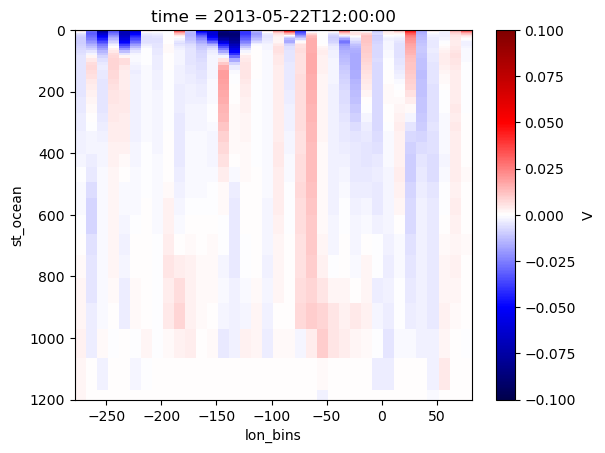

In [16]:
#view test
from random import randint as randint
#random time index for testing
Tind = randint(0,CrossV_10deg_bins.time.count().values)

CrossV_10deg_bins.V.isel(time=Tind).plot(vmin=-.1,vmax=.1,cmap='seismic')
plt.ylim(1200,0)


(1200.0, 0.0)

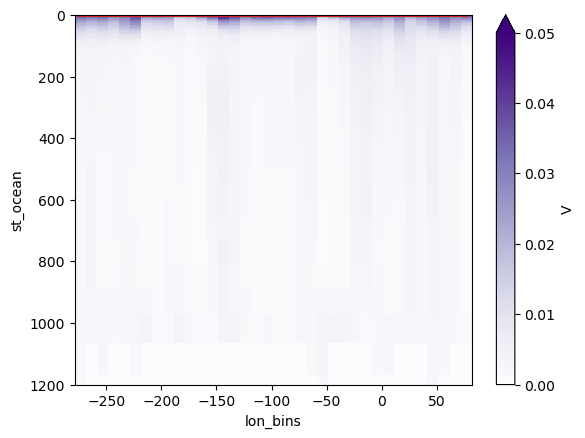

In [17]:
CrossV_10deg_bins.V.std('time').plot(vmin=0,vmax=.05,cmap='Purples')
CrossV_10deg_bins.st_ocean.isel(st_ocean=CrossV_10deg_bins.V.std('time').argmax('st_ocean')).plot(x='lon_bins',color='tab:red',linewidth=3)
plt.ylim(1200,0)
#maximum standard deviation/variability seem to be always at the surface